# Lab CMBLenses

## Model

In [1]:
using CMBLensing, CMBLensingInferenceTestProblem
using CUDA, LaTeXStrings, MCMCDiagnosticTools, Plots, ProgressMeter, Random, Zygote
using LinearAlgebra, Statistics
ENV["LINES"] = 10;

In [2]:
using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
prob = load_cmb_lensing_problem(storage = Array,
                                T = Float32,
                                Nside = 64);

In [4]:
target = CMBLensingTarget(prob);

In [5]:
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart)

(CMBLensingInferenceTestProblem.var"#to_vec#2"(), CMBLensingInferenceTestProblem.var"#from_vec#3"{Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{Array{Float32, 3}}, LambertMap{Array{Float32, 2}}, ComponentArrays.ComponentVector{Float32, Vector{Float32}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}}(Float32[-4.7993712, -10.132681, -13.010162, -9.098768, -3.4189508, -2.647602, -2.2184951, -1.8052056, -3.8572881, -6.549067  …  -1.4671382f-6, -1.5210153f-6, -1.5569877f-6, -1.597326f-6, -1.6578678f-6, -1.7366059f-6, -1.8154062f-6, -1.8714119f-6, -1.609438, 0.0]))

## Sample

In [6]:
spl=MCHMC(10.0, 10.0*sqrt(50); init_eps=0.01, varE_wanted=0.001, sigma=one(LenseBasis(diag(target.Λmass))))

MicroCanonicalHMC.Sampler(Settings(MersenneTwister(0), 0.001, 0, 20, 10, "LF", 0.01, nothing, nothing), Hyperparameters(10.0, 70.71067811865476, 0.0, 0.1931833275037836, Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), MicroCanonicalHMC.Leapfrog)

In [7]:
samples = Sample(spl, target, 500; dialog=true)

[ Info: Using given sigma ✅
[ Info: Using given eps ✅
[ Info: Using given L ✅


501-element Vector{Any}:
 [-4.781805038452148, -10.115113258361816, -12.992595672607422, -9.081202507019043, -3.4013853073120117, -2.6300344467163086, -2.2009286880493164, -1.7876393795013428, -3.8397207260131836, -6.531499862670898  …  -1.556987626827322e-6, -1.5973259905877057e-6, -1.657867642279598e-6, -1.7366054407830234e-6, -1.815406449168222e-6, -1.8714119960350217e-6, -1.6094379425048828, 0.0, 0.0, 98678.2265625]
 [-4.718954212774696, -10.159082552390917, -12.978971629115845, -9.125396634907059, -3.4128275146821903, -2.5976557344566302, -2.1296722186280697, -1.7782546639800172, -3.836807954576407, -6.529815788770625  …  -1.5795503002225397e-6, -1.614911870482936e-6, -1.6736405589489053e-6, -1.748366098576306e-6, -1.8265143611258158e-6, -1.8892207455305334e-6, -1.716761074016233, 0.12288409394023206, -1.2414505783526693, 98628.27342306584]
 [-4.662073014198295, -10.180364077195, -12.938632983028356, -9.191162204188954, -3.4229391732266428, -2.5556463335947237, -2.047602414029897,

In [8]:
samples_redux = []
for sample in samples
    if all(isfinite.(sample))
            append!(samples_redux, [sample])
    end
end    

In [9]:
_samples = zeros(length(samples), length(samples[1]), 1)
_samples[:, :, 1] = mapreduce(permutedims, vcat, samples)
_samples = permutedims(_samples, (1,3,2))
ess, rhat = MCMCDiagnosticTools.ess_rhat(_samples)

([12.836499114092272, 13.868583038327214, 23.618227204432877, 15.067012428374685, 14.202388619169023, 13.69576782883285, 19.562470195042913, 13.734964932891753, 15.929523123788663, 3.576500104456065  …  7.520129599087579, 7.511987898849137, 7.325986428811852, 7.263497931876982, 7.576042845337902, 8.200503962770586, 46.681548451219165, 22.480392599759195, 468.75490709131475, 36.72465961808616], [1.0398864915753827, 1.042060317373944, 1.0110202651815776, 1.0737254366680757, 1.1265294544820534, 1.012355418147816, 1.0096233136696486, 1.0988316640565001, 1.0391063361349666, 1.2218683396417243  …  1.0536602119952256, 1.0590750664803243, 1.067124850874118, 1.0612054652745162, 1.0386019408757479, 1.0134070526095775, 1.0794741724515655, 1.0306250423166707, 0.9980350223202187, 1.0129103072451635])

In [10]:
_ess = median(ess)

11.786385595711385

In [11]:
_rhat = median(rhat)

1.0463795542404881

## Plotting

In [12]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [13]:
rs = [sample[end-3] for sample in samples]
Aϕs = [sample[end-2] for sample in samples];

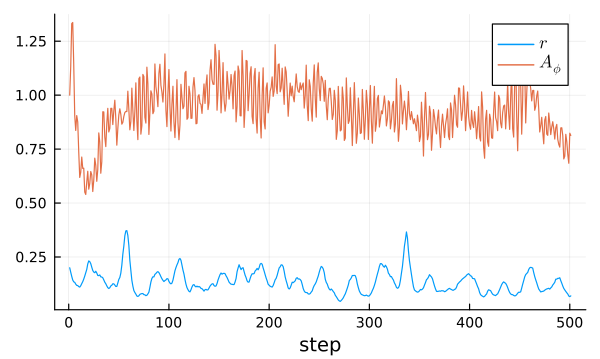

In [14]:
plot(exp.(rs), label=L"r", xlabel="step")
plot!(exp.(Aϕs), label=L"A_\phi")


In [15]:
Energy = [sample[end-1] for sample in samples];
std(Energy)^2/12000

1.783460176669818e-5

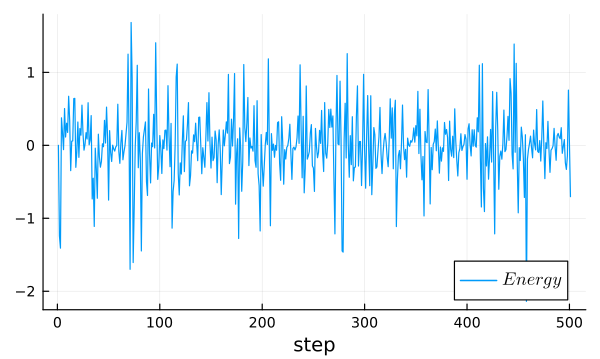

In [16]:
plot(Energy, label=L"Energy", xlabel="step")

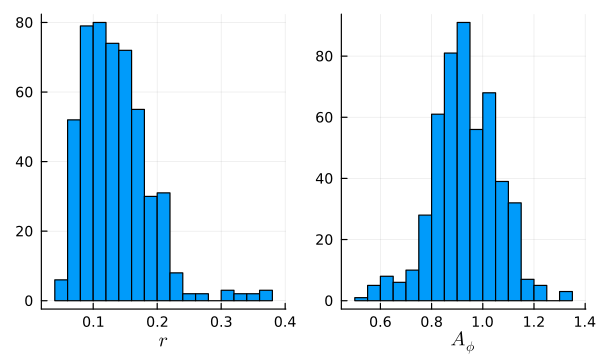

In [17]:
plot(histogram(exp.(rs), xlabel=L"r", label=nothing, lw=1),
    histogram(exp.(Aϕs), xlabel=L"A_\phi", label=nothing, lw=1))

In [18]:
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart)
last_sample = from_vec(samples[end][1:end-2])

12290-element Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{Array{Float64, 3}}, LambertMap{Array{Float64, 2}}, ComponentArrays.ComponentVector{Float32, Vector{Float32}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}:
  -5.091701068745383
  -9.717660534877579
 -13.35031020768476
   ⋮
  -2.6628775596618652
  -0.20663614571094513

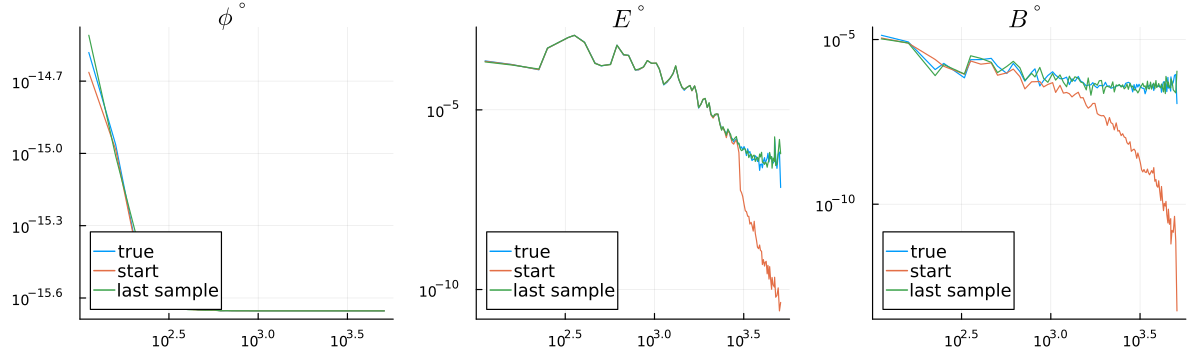

GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27


In [19]:
ps = map([(:ϕ°,:I,L"L",L"\phi^\circ"), (:f°,:E,"L\ell",L"E^\circ"), (:f°,:B,L"\ell",L"B^\circ")]) do (k1, k2, xlabel, title)
    plot(get_Cℓ(prob.Ωtrue[k1][k2]); label="true", xlabel, title)
    plot!(get_Cℓ(prob.Ωstart[k1][k2]); label="start", xlabel, title)
    plot!(get_Cℓ(last_sample[k1][k2]); label="last sample", xlabel, title)
end
plot(ps..., layout=(1,3), xscale=:log10, yscale=:log10, size=(1000,300), legend=:bottomleft)

In [ ]:
samps = [∇²*from_vec(sample[1:end-2]).ϕ°/2 for sample in samples[100:end]]
anim = @animate for i in 1:length(samps)
    motionblur = [0.5, 1, 0.5]
    frame = sum(circshift(samps, i)[1:length(motionblur)] .* motionblur) / sum(motionblur)
    plot(1 * frame, clims=(-0.5, 0.5), c=:thermal, title="κ samples")
end;

In [ ]:
mp4(anim, "kappa_samples.mp4", fps = 25)